In [1]:
# Installation Long Shhort-Term Memory with PyTorch + Lightning
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.optim import Adam
import lightning as l
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# LightningLSTM: Là lớp định nghĩa mô hình LSTM của bạn, kế thừa từ l.LightningModule (PyTorch Lightning).
# l.LightningModule: Được thiết kế để đơn giản hóa việc huấn luyện mô hình bằng cách tích hợp việc quản lý vòng lặp huấn luyện, tối ưu hóa, và kiểm tra.

# Cấu tạo của một batch
# Trong huấn luyện mạng nơ-ron, đặc biệt là với dữ liệu chuỗi như trong LSTM, dữ liệu đầu vào không được xử lý từng mẫu riêng lẻ mà được chia thành batch. Batch là một tập hợp nhiều mẫu được xử lý cùng lúc nhằm tăng hiệu quả tính toán và ổn định trong huấn luyện.

# 1. Thành phần của một batch
# Một batch bao gồm:

# (a) Input tensor (X):
# Kích thước: ({batch_size}, {seq_length}, {input_size})
# batch_size: Số lượng mẫu trong batch.
# seq_length: Độ dài của chuỗi thời gian (số bước thời gian trong mỗi chuỗi).
# input_size: Số lượng đặc trưng (features) trong mỗi bước thời gian.

# (b) Target tensor (y):
# Kích thước: ({batch_size}, {output_size})
# batch_size: Số lượng mẫu trong batch (phải giống batch_size của X).
# output_size: Số lượng giá trị đích (targets) cần dự đoán cho mỗi mẫu.

# 2. Ví dụ cụ thể
# Kích thước của X trong batch:
# (32,60,1)
# Ý nghĩa:
# Có 32 mẫu.
# Mỗi mẫu là một chuỗi 60 ngày.
# Mỗi ngày chỉ có một đặc trưng (giá cổ phiếu).

# Target tensor
# Giả sử bạn muốn dự đoán giá cổ phiếu ngày thứ 61 cho mỗi chuỗi, kích thước của y sẽ là:
# (32,1)
# Ý nghĩa:

# Có 32 giá trị đích, tương ứng với 32 mẫu trong batch.
# Mỗi giá trị là giá cổ phiếu của ngày tiếp theo (ngày thứ 61).
class LightningLSTM(l.LightningModule):
    
    # self là tham chiếu đến đối tượng hiện tại của lớp (instance of the class).
    def __init__(self):
        # Gọi hàm khởi tạo của lớp cha
        super().__init__()
        
        # . input_size (Kích thước đầu vào)
        # Ý nghĩa:
        
        # Đây là số lượng đặc trưng (features) trong mỗi thời điểm của dữ liệu chuỗi mà mô hình LSTM sẽ nhận làm đầu vào.
        # Trong ngữ cảnh dữ liệu chuỗi thời gian, mỗi thời điểm thường chỉ có một giá trị đại diện, chẳng hạn như giá đóng cổ phiếu, nhiệt độ, hoặc bất kỳ thông số nào bạn đang dự đoán.
        # Tại sao input_size = 1?
        # Trong đoạn mã đang xử lý chuỗi thời gian, nơi mỗi bước thời gian có một giá trị (giá đóng cổ phiếu ở một thời điểm). Do đó, mỗi thời điểm trong chuỗi đầu vào chỉ có một đặc trưng, dẫn đến input_size = 1.
        
        # 2. hidden_size (Kích thước tầng ẩn)
        # Ý nghĩa:
        
        # Đây là số lượng tế bào ẩn (hidden cells) trong mỗi tầng LSTM.
        # Mỗi tế bào ẩn giữ thông tin về trạng thái tạm thời (short-term memory) và trạng thái lâu dài (long-term memory). Số lượng tế bào ẩn kiểm soát khả năng ghi nhớ của mô hình.
        # hidden_size ảnh hưởng trực tiếp đến khả năng mô hình hóa các mẫu phức tạp trong dữ liệu chuỗi thời gian.
        # Tại sao hidden_size = 50?
        # Đây là một giá trị do người dùng thiết lập dựa trên kinh nghiệm hoặc thử nghiệm:
        
        # Giá trị lớn hơn (ví dụ, 100, 200) thường giúp mô hình học được các mẫu phức tạp hơn, nhưng đồng thời cũng làm tăng độ phức tạp tính toán và nguy cơ quá khớp (overfitting).
        # Giá trị nhỏ hơn (ví dụ, 10, 20) có thể khiến mô hình học không đủ tốt các mẫu trong dữ liệu, dẫn đến underfitting.
        # 50 là một lựa chọn phổ biến, cân bằng giữa khả năng học và độ phức tạp tính toán, nhất là với dữ liệu chuỗi thời gian có tính chất đơn giản hoặc trung bình.
        # batch_first=True: Dữ liệu đầu vào có dạng (batch_size, seq_length, input_size).
        # self.lstm: Tạo lớp LSTM tự động học trọng số (weights) và bias.
        self.lstm = nn.LSTM(input_size = 1, hidden_size = 50, batch_first=True)

        # LSTM trả về một tensor chứa thông tin thời gian, nhưng mục tiêu cuối cùng của là dự đoán một giá trị tại mỗi bước 
        # thời gian (ví dụ: giá cổ phiếu ngày tiếp theo). Để chuyển đổi từ output của LSTM (dạng vector ẩn) sang một giá trị đầu 
        # ra duy nhất, ta cần một lớp FC.
        # nn.Linear(50, 1)
        # Input kích thước 50: Giá trị này tương ứng với hidden_size trong lớp LSTM.
        # Mỗi tế bào trong LSTM tạo ra 50 giá trị (vector ẩn) tại bước thời gian cuối cùng. Lớp nn.Linear sẽ nhận vector này làm đầu vào.
        # Output kích thước 1: Muốn dự đoán một giá trị duy nhất (ví dụ: giá cổ phiếu ngày tiếp theo). Do đó, lớp FC này chuyển đổi vector 
        # ẩn kích thước 50 thành một giá trị đầu ra duy nhất.
        self.fc = nn.Linear(50, 1)
        
    def forward(self, x):
        # Pass the data to lstm and store it in lstm_out 
        lstm_out, _ = self.lstm(x)
        # Because lstm will return a list of STM values from each LSTM unit that unrolled
        # And we just want the last STM, we get the data from the last index  
        # Kích thước của lstm_out[batch_size, seq_length, hidden_size]
        # batch_size: Số lượng chuỗi trong mỗi batch (bao nhiêu mẫu được xử lý cùng lúc).
        # seq_length: Độ dài của chuỗi thời gian.
        # hidden_size: Số lượng giá trị ẩn (output features) tại mỗi bước thời gian.
        # : là lấy hết, -1 là lấy phần tử cuối cùng
        prediction = self.fc(lstm_out[:, -1, :])
        return prediction

    def configure_optimizers(self):
        # Use Adam to optimize the weight and bias
        # self.parameters(): Lấy tất cả các tham số của mô hình (LSTM và FC).
        # lr is learning rate
        return Adam(self.parameters(), lr = 0.001)
        
    # Nhận 1 batch từ train_loader và index của batch đó
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        # Sử dụng hàm Mean Squared Error (MSE) để tính lỗi giữa giá trị dự đoán (y_pred) và giá trị thực (y).
        loss = nn.MSELoss()(y_pred, y)
        self.log("train_loss", loss)
        return loss
        
    # Hoạt động tương tự như training_step, nhưng dành cho dữ liệu kiểm tra (validation data).
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred, y)
        self.log("val_loss", loss)
        return loss

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Xử lý dữ liệu tương tự file 1
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
apple = pd.read_csv('archive/stocks/AAPL.csv')
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(apple[['Close']])

In [6]:
seq_length = 60  
X, y = create_sequences(scaled_data, seq_length)

In [7]:
# Chuyển mảng sang tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [8]:
# TensorDataset là một class của PyTorch để đóng gói các torch.Tensor thành một dataset.
# Nó kết hợp các tensor X_tensor (dữ liệu đầu vào) và y_tensor (nhãn) lại thành một cặp (input, label).
# Giúp quản lý dữ liệu dễ dàng hơn, đặc biệt khi cần phân chia dữ liệu hoặc tạo các batch.
dataset = TensorDataset(X_tensor, y_tensor)

# Tính toán kích thước của tập huấn luyện, chiếm 80% số lượng dữ liệu (len(X)).
# Kích thước tập kiểm tra (test_size) sẽ là phần còn lại (20%).
train_size = int(len(X) * 0.8)

# Hàm random_split nhận hai đối số chính:
# dataset: Tập dữ liệu gốc (toàn bộ dữ liệu được gói trong TensorDataset).
# [train_size, len(dataset) - train_size]: Một danh sách chứa kích thước tương ứng cho tập huấn luyện (train_dataset) và tập kiểm tra (test_dataset).
# Dùng hàm random_split của PyTorch để chia dataset (tập dữ liệu gốc) thành hai phần:
# train_dataset: Tập huấn luyện, có train_size mẫu.
# test_dataset: Tập kiểm tra, có len(dataset) - train_size mẫu.
# Dữ liệu được chia ngẫu nhiên, không có thứ tự cố định.
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])


# Tạo một DataLoader cho tập huấn luyện train_dataset.
# Các tham số:
# batch_size=32: Chia dữ liệu thành các batch (lô) có kích thước 32. Điều này giúp xử lý dữ liệu theo từng nhóm nhỏ thay vì toàn bộ dữ liệu một lần.
# shuffle=True: Ngẫu nhiên hóa thứ tự dữ liệu trong mỗi epoch, giúp mô hình không bị học theo thứ tự dữ liệu.
# num_workers=4: Sử dụng 4 luồng (workers) để tải dữ liệu song song, giúp tăng tốc độ tải.
# persistent_workers=True: Giữ các workers hoạt động trong suốt quá trình huấn luyện để tăng hiệu suất khi huấn luyện nhiều epoch.
# Lý do sử dụng:
# Tạo batch dữ liệu nhỏ, giúp huấn luyện hiệu quả và tận dụng được khả năng tính toán song song.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)

# Ý nghĩa:
# Tương tự train_loader, nhưng dành cho tập kiểm tra test_dataset.
# Khác biệt chính:
# shuffle=False: Không ngẫu nhiên hóa dữ liệu kiểm tra vì thứ tự kiểm tra không quan trọng.
# Lý do sử dụng:
# Đảm bảo tập kiểm tra được chia thành các batch và được xử lý tuần tự để đánh giá mô hình.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)

In [23]:
# Training model LSTM
model = LightningLSTM()

#  Tạo một `Trainer` từ PyTorch Lightning, chịu trách nhiệm quản lý quá trình huấn luyện mô hình.
# max_epochs=50: Số lượng epochs (chu kỳ) mà mô hình sẽ được huấn luyện. Một epoch là khi toàn bộ tập dữ liệu huấn luyện được đưa qua mô hình một lần.
# log_every_n_steps=1: Ghi log sau mỗi bước cập nhật mô hình (mỗi batch). Điều này giúp theo dõi quá trình huấn luyện chi tiết.
trainer = l.Trainer(max_epochs=50, log_every_n_steps=1)

# model: Mô hình LightningLSTM cần được huấn luyện.
# train_loader: Bộ dữ liệu huấn luyện, đã được chia thành các batch và cung cấp qua DataLoader.
# test_loader: Bộ dữ liệu kiểm tra (validation set), dùng để kiểm tra mô hình sau mỗi epoch.
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 10.6 K | train
1 | fc   | Linear | 51     | train
----------------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.


In [25]:
# Dự đoán và trực quan hóa
# Đưa mô hình vào chế độ evaluation (kiểm tra/dự đoán).
# Trong chế độ này, các cơ chế như dropout hoặc batch normalization sẽ bị vô hiệu hóa.
# Điều này giúp đảm bảo kết quả dự đoán nhất quán, không thay đổi giữa các lần chạy.
model.eval()

# Tạo hai danh sách trống để lưu kết quả:
# predicted: Lưu các giá trị mà mô hình dự đoán.
# actual: Lưu các giá trị thực tế từ tập kiểm tra (test_loader).
predicted = []
actual = []
# Vô hiệu hóa tính năng ghi nhận lịch sử gradient trong PyTorch.
# Khi kiểm tra hoặc dự đoán, ta không cần tính toán gradient, giúp tiết kiệm bộ nhớ và tăng tốc độ tính toán.
# Mọi phép tính trong khối này sẽ không yêu cầu ghi nhớ gradient.
# Việc tối ưu hóa đã được hoàn thành ở bước training rồi.
with torch.no_grad():
    # Với mỗi batch (tập dữ liệu) trong test_loader (tập dữ liệu trong test_loader được chia nhỏ thành các batch)
    for batch in test_loader:
        # Mỗi bactch sẽ gồm chuỗi X (chuỗi data mà model nhìn vào) và giá trị thực tế ngày cần dự đoán 
        x, y = batch
        # Lấy kết quả dự đoán model
        y_pred = model(x) 
        
        # Tạo 1 danh sách để lưu các giá trị dự đoán
        # y_pred.squeeze(): Loại bỏ chiều dư thừa của tensor, nếu có (ví dụ, từ [batch_size, 1] thành [batch_size]).
        # tolist(): Chuyển tensor PyTorch thành danh sách Python.
        predicted.extend(y_pred.squeeze().tolist())

        # Thêm các giá trị thực tế từ y vào danh sách actual.
        actual.extend(y.squeeze().tolist())
        
# Chuyển giá trị dự đoán từ phạm vi đã chuẩn hóa (scaled range) về giá trị gốc ban đầu.
# np.array(predicted): Chuyển danh sách predicted thành một mảng numpy.
# .reshape(-1, 1): Định dạng lại mảng thành cột vector với kích thước [n_samples, 1]. 
# reshape là một phương thức trong NumPy cho phép thay đổi kích thước (shape) của mảng (array) mà không làm thay đổi dữ liệu.
#  Tham số của reshape
# reshape(new_rows, new_cols): Quy định số hàng (rows) và số cột (cols) của mảng đầu ra.
# -1: Là một giá trị đặc biệt, yêu cầu NumPy tự tính toán số hàng hoặc số cột dựa trên kích thước tổng thể của mảng.
# scaler.inverse_transform(): Dùng bộ biến đổi (scaler) để chuyển giá trị từ dạng chuẩn hóa (normalized) về giá trị ban đầu.
predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))
actual = scaler.inverse_transform(np.array(actual).reshape(-1, 1))

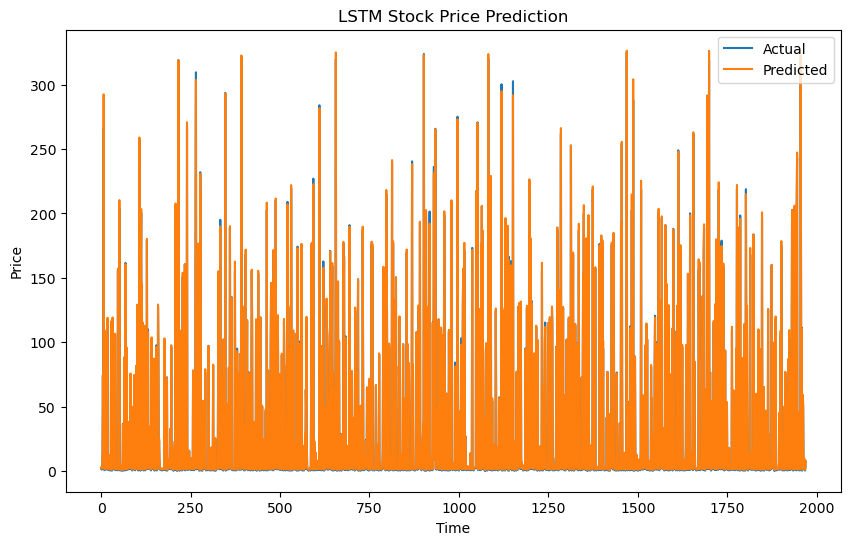

In [31]:
# Trực quan hóa bằng biểu đồ cột
plt.figure(figsize=(10, 6))
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [1]:
# Đánh giá mô hình LSTM:

In [3]:
# 1. Mean Absolute Error (MAE): Trung bình độ lệch tuyệt đối giữa giá trị dự đoán và giá trị thực tế.
# 2. Mean Squared Error (MSE): Trung bình bình phương sai số giữa giá trị dự đoán và thực tế.
# 3. Root Mean Squared Error (RMSE): Căn bậc hai của MSE, giúp trực quan hóa sai số.
# 4. Mean Absolute Percentage Error (MAPE): Tỷ lệ sai số trung bình so với giá trị thực tế (phần trăm).
# 5. R-squared (R²): Đánh giá mức độ phù hợp của mô hình.
import numpy as np

In [5]:
def calculate_matrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mse((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {
        "MAE" : mae,
        "MSE" : mse,
        "RMSE" : rmse,
        "MAPE (%)" : mape
    }

In [ ]:
metrics = calculate_matrics(actual, predicted)

for key, value in metrics.items():
    print(f"{key}: {value}")